# Model

After pre-processing is complete and the data has been stored in a file, load data and train the model.

The format of the data is a np array of shape (total_runs_from_all_subjects, n_channels, n_timestamps)

Which translates to (5184, 22, 1125) for this dataset and these params.

In [1]:
import h5py

def save(filename, inputs, targets):
  file = h5py.File(filename + '.h5', 'w')
  file.create_dataset('inputs', data=inputs)
  file.create_dataset('targets', data=targets)
  file.close()


def load(filename):
  file = h5py.File(filename+'.h5', 'r')
  inputs = file['inputs'][:]
  targets = file['targets'][:]
  file.close()
  return inputs, targets

In [2]:
inputs, targets = load('all_subject_runs')

In [3]:
print(inputs.shape)

(5184, 22, 1125)


In [11]:
from tensorflow import keras
from keras.constraints import max_norm
import tensorflow as tf
import keras.backend as K
from keras_uncertainty.layers import DropConnectDense
from keras_uncertainty.utils import numpy_entropy
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import StochasticClassifier
from livelossplot import PlotLossesKeras

Maybe convert the epochs to a dataframe
Like:

epcohs_df = windows_dataset.datasets[0].windows.to_data_frame()


Maybe make one of the FC layers use UQ

**SET KERNEL MAXIMUM NORM CONSTRAINT AT 2 AND 0.5 FOR CONVOLUTIONAL AND FC LAYERS RESPECTIVELY**

*Temporal convolution has size of 1 x TimePoints while spatial convolution has size Channels x 1. Spatial convolution is applied after temporal*

In [12]:
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))  

def uncertainty(probs):
  return numpy_entropy(probs, axis=-1)


def create_model():

      weights_filepath = 'TBD'

      C = 22          # Number of electrodes
      T = 1125        # Time samples of network input

      k_1 = 40        # K is number of convolutional kernels. SUBJECT TO HYPERPARAM TUNING
      f_1 = 25        # F is kernel size SUBJECT TO HYPERPARAM TUNING
      s_1 = (1,1)     # Strides size
      p_1 = (0,0)     # Padding size

      k_2 = 40
      f_2 = C
      s_2 = (1,1)
      p_2 = (0,0)

      m = 0.9
      alpha = 1
      f_p = (1, 75)   # Fp is pooling size
      s_p = (1, 15)   # Sp is pool stride

      Nc = 4          # Number of classes

      # THIS IS SHALLOWCONVNET from Schirmeister
      model = keras.models.Sequential([
              keras.layers.Input(shape=(C, T, 1)),
              keras.layers.Conv2D(f_1,  k_1, padding = 'SAME',
                                  activation="linear",
                                  input_shape = (C, T, 1),
                                  kernel_constraint = max_norm(2)),
              keras.layers.Conv2D(f_2,  k_2, padding = 'SAME',
                                  input_shape = (1, C, T),
                                  activation="linear",
                                  kernel_constraint = max_norm(2)),

              keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-05),
              keras.layers.Activation(square),
              keras.layers.AveragePooling2D(pool_size= f_p, strides= s_p),
              keras.layers.Activation(log),
              keras.layers.Dropout(0.5),     # value obtained from ShallowConvnet

              keras.layers.Flatten(),
              DropConnectDense(Nc, activation='softmax', prob=0.1, kernel_constraint = max_norm(0.5))
          ])

      # model.load_weights(weights_filepath)
      optimizer = keras.optimizers.Adam(learning_rate=1e-4)
      model.compile(loss="categorical_crossentropy",
                    optimizer=optimizer, metrics=["accuracy"])
      return model

print(f'executed')


executed


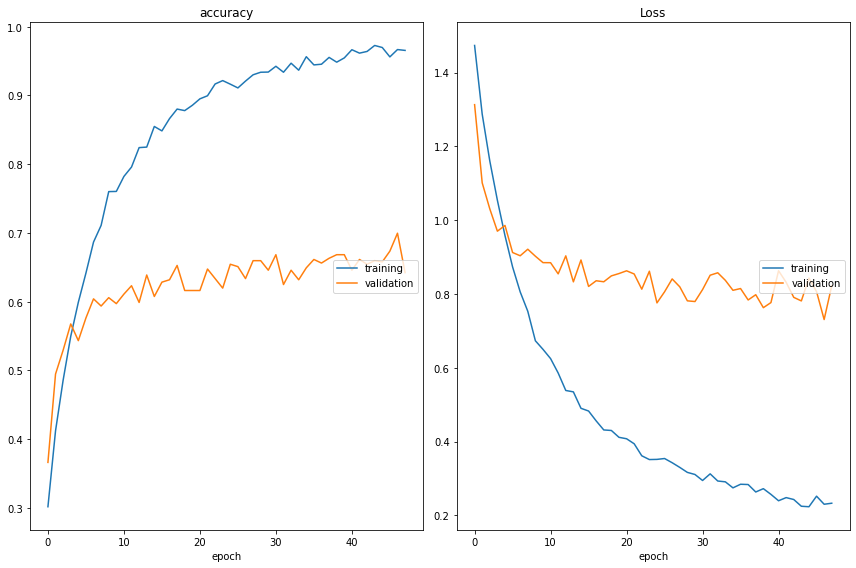

accuracy
	training         	 (min:    0.302, max:    0.973, cur:    0.966)
	validation       	 (min:    0.366, max:    0.700, cur:    0.642)
Loss
	training         	 (min:    0.224, max:    1.474, cur:    0.233)
	validation       	 (min:    0.731, max:    1.313, cur:    0.823)

Epoch 48: saving model to weights/dropconnect/dropconnect.ckpt
126/126 [==============================] - 56s 441ms/step - loss: 0.2331 - accuracy: 0.9655 - val_loss: 0.8226 - val_accuracy: 0.6424


NameError: name 'unc_preds' is not defined

In [13]:
# Use 1 subject as Final test set.
# Use remaining 8 subjects as train/val

n_epochs= 50
n_s = 9  # Number of subjects
num_trials_per_subject = 576 # Dataset-derived parameter. Total of 576 trials per subject
checkpoint_path = 'weights/dropconnect/dropconnect.ckpt'



# Train set is first 8 subjects
# This shit is bordering cross-subject data contamination man...]
train_set = dict(inputs= inputs[:(576 * (n_s - 1))], targets= targets[:(576 * (n_s - 1))])

# Test set is last subject
test_set = dict(inputs= inputs[(576 * (n_s - 1)):], targets= targets[(576 * (n_s - 1)):])

# kfold split on the 8 training subjects data
kfold = KFold(n_splits=n_s - 1, shuffle=False)

fit_params = {"epochs: ", n_epochs}
early_stopping = EarlyStopping(monitor='loss', patience=3)
saving_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

inputs = train_set['inputs']
targets = train_set['targets']

print(f'Starting Training')

# JUST DO REGULAR CROSS-VALIDATION.
# MODEL IS OVERFITTING LIKE CRAZY
# K-fold Cross Validation model evaluation
fold_no = 1
for train, val in kfold.split(inputs, targets):

  X_train = inputs[train]
  X_val = inputs[val]
  Y_train = targets[train]
  Y_val = targets[val]

  # Define the model architecture
  model = create_model()
  model.fit(X_train, Y_train, epochs=n_epochs,
            callbacks=[early_stopping, PlotLossesKeras(), saving_callback],
           validation_data= (X_val, Y_val))

  mc_model = StochasticClassifier(model)
  y_pred = tf.cast(tf.argmax(unc_preds, axis=1), tf.float32)
  Y_val = tf.argmax(Y_val, axis=1)

  acc = accuracy_score(Y_val, y_pred)
  print(f'Average Accuracy and Entropy for {fold_no}: {acc} {avg_entropy}')
  # Increase fold number
  fold_no = fold_no + 1




In [ ]:
# This is what I remember from the whiteboard.

unc_preds = mc_model(X_test)
# results in matrix (F, N, C) Where F is number forward passes, N is X_test number of trials and C is number of classes.
# Take the mean of mean of these softmax probs or entropy along axis=1 to get matrix (N, C). 
# Then plot a histogram plt.hist() of the entropy of correct and incorrect predictions. To see the overlap in the distributions.
# The better UQ method will probably have better distinguishing abilities.
# 
# Can do this by taking matrix (N,C) and selecting where predicted class equals Y_test for that input. Then putting those 
# entropies into a list for correct. Everything else goes into list for correct